
# 
# IMPORTS
# 

In [174]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scipy import signal
from sklearn.linear_model import LinearRegression
import os
import pickle
import warnings


import tabata as tbt
from tabata import Opset, Selector

In [175]:
%reload_ext autoreload
%autoreload 2

In [181]:
fieldname = 'data/out/AFL1EB_C.h5'




##  Dictionnaire des Variables

Les données sont structurées sous forme de **séries temporelles** (indexées à la seconde). Voici la description de chaque paramètre physique :

### 1. Paramètres de Trajectoire
| Variable | Nom Complet | Unité | Description |
| :--- | :--- | :---: | :--- |
| **ALT** | **Altitude** | mètres (m) | Hauteur de l'appareil par rapport au niveau moyen de la mer. |
| **Vz** | **Vitesse Verticale** | m/s | Taux de montée (positif) ou de descente (négatif) de l'avion. |



### 2. Paramètres de Performance (Vitesse & Forces)
| Variable | Nom Complet | Unité | Description |
| :--- | :--- | :---: | :--- |
| **TAS** | **True Airspeed** | m/s | Vitesse réelle de l'avion par rapport à la masse d'air environnante. |
| **F** | **Force / Poussée** | Newton (N) | Mesure des forces appliquées (généralement la poussée des moteurs ou la traînée). |
| **Masse** | **Masse totale** | kg | Masse actuelle de l'avion (diminue avec la consommation de carburant). |

### 3. Paramètres Atmosphériques (Modèle ISA)
*L'ISA (International Standard Atmosphere) est le modèle de référence utilisé en aéronautique.*

| Variable | Nom Complet | Unité | Description |
| :--- | :--- | :---: | :--- |
| **Tisa** | **Température ISA** | Kelvin (K) | Température de l'air ambiant à l'altitude donnée selon le modèle standard. |
| **CRsa** | **Climb Rate (Std)** | K / m/s | Variable de référence liée au taux de montée dans des conditions standards. |

---

##  Guide d'interprétation


1. **Relation ALT / Tisa** : Normalement, la température (`Tisa`) diminue à mesure que l'altitude (`ALT`) augmente (environ -6.5°C par 1000m dans la troposphère).
2. **Relation Masse / F** : Une masse plus élevée nécessite généralement une force (`F`) plus importante pour maintenir une vitesse stable ou pour monter.
3. **Vz** : C'est la dérivée de l'altitude par rapport au temps ($Vz = \frac{dALT}{dt}$).



# Analyse descriptive de mes données 

# Étape 1 : Chargement et Exploration des données (Opset)

In [183]:
path = "data/in/AFL1EB.h5"
with open(path, "r", errors="ignore") as f:
    print(f.read(200))


version https://git-lfs.github.com/spec/v1
oid sha256:c5e11d26efbe712a2a39f88281cd0867ebe750a56992a1eb393668b7ae209a43
size 21552822



In [184]:
filename = 'data/in/AFL1EB.h5' 


ds = Opset(filename)

print(f"Nombre de vols chargés : {len(ds)}")


colonnes = ds[0].columns
print(f"Variables disponibles dans les signaux : \n{list(colonnes)}")

print("\nAperçu des données du vol 0 :")
print(ds[0].head())

Nombre de vols chargés : 52
Variables disponibles dans les signaux : 
['ALT[m]', 'Tisa[K]', 'TAS[m/s]', 'Vz[m/s]', 'Masse[kg]', 'F[N]']

Aperçu des données du vol 0 :
                       ALT[m]     Tisa[K]  TAS[m/s]   Vz[m/s]     Masse[kg]  \
record_00                                                                     
2012-07-10 11:08:00 -1.267968  829.894823       0.0  0.017541  15217.558677   
2012-07-10 11:08:01 -1.267968  829.894823       0.0  0.016004  15217.558677   
2012-07-10 11:08:02 -1.267968  829.894823       0.0  0.014466  15217.558677   
2012-07-10 11:08:03 -1.267968  829.894823       0.0  0.012929  15217.558677   
2012-07-10 11:08:04 -1.267968  829.894823       0.0  0.011392  15217.558677   

                     F[N]  
record_00                  
2012-07-10 11:08:00   0.0  
2012-07-10 11:08:01   0.0  
2012-07-10 11:08:02   0.0  
2012-07-10 11:08:03   0.0  
2012-07-10 11:08:04   0.0  


# Étape 2 : Identification du Décollage (Sélecteur de début)

In [185]:
warnings.filterwarnings("ignore", message="X does not have valid feature names*")

PKL_FILE = "selectors_AFL1EB.pkl"

def save_selectors(S_debut, S_fin, filename=PKL_FILE):
    if len(S_debut.selected) == 0 or len(S_fin.selected) == 0:
        print("Sauvegarde annulée : sélection(s) vide(s).")
        return
    obj = {
        "S_debut_selected": S_debut.selected,
        "S_debut_variables": list(S_debut.variables),
        "S_debut_idcodes": S_debut.idcodes,
        "S_debut_clf": S_debut._clf,
        "S_fin_selected": S_fin.selected,
        "S_fin_variables": list(S_fin.variables),
        "S_fin_idcodes": S_fin.idcodes,
        "S_fin_clf": S_fin._clf,
    }
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
    print("Sélecteurs sauvegardés :", filename)

def load_selectors(ds, filename=PKL_FILE):
    with open(filename, "rb") as f:
        obj = pickle.load(f)

    S_debut = Selector(ds)
    S_debut.selected  = obj["S_debut_selected"]
    S_debut.variables = set(obj["S_debut_variables"])
    S_debut.idcodes   = obj["S_debut_idcodes"]
    S_debut._clf      = obj["S_debut_clf"]

    S_fin = Selector(ds)
    S_fin.selected  = obj["S_fin_selected"]
    S_fin.variables = set(obj["S_fin_variables"])
    S_fin.idcodes   = obj["S_fin_idcodes"]
    S_fin._clf      = obj["S_fin_clf"]

    return S_debut, S_fin

if os.path.exists(PKL_FILE):
    S_debut, S_fin = load_selectors(ds)
    print("Sélecteurs rechargés.")
else:
    S_debut = Selector(ds)
    S_fin   = Selector(ds)
    print("Aucun pkl : faire les sélections puis entraîner.")

print("labels début :", len(S_debut.selected))
print("labels fin   :", len(S_fin.selected))


Sélecteurs rechargés.
labels début : 13
labels fin   : 13


In [134]:
S_debut.plot(name="ALT[m]")

In [66]:

S_fin.plot(name="Vz[m/s]")


In [135]:
S_debut.make_indicators()
S_debut.fit()

S_fin.make_indicators()
S_fin.fit()

save_selectors(S_debut, S_fin)
print(len(S_debut.selected), len(S_fin.selected))


First keeping 17 indicators over 124
Then  keeping 5 indicators over 124
First keeping 16 indicators over 485
Then  keeping 1 indicators over 485
Sélecteurs sauvegardés : selectors_AFL1EB.pkl
13 13


In [208]:
S_debut.plot(name="ALT[m]")

In [209]:

S_fin.plot(name="Vz[m/s]")

## Entraînement du détecteur des phases de vol

Le vol est découpé en deux instants clés afin d’isoler la **phase de montée** :
le début de la montée et la fin de la montée (passage en palier).

### Début de la montée
Le début de la montée correspond au moment où l’avion quitte le sol et où
l’altitude commence à augmenter de manière continue.

- Signal utilisé : `ALT[m]`
- Critère :
  - l’altitude quitte le plateau initial (avion au sol),
  - `ALT[m]` commence à croître de façon nette.
- Méthode :
  - sélection manuelle de cet instant sur plusieurs vols à partir de la courbe d’altitude,
  - apprentissage supervisé pour généraliser la détection à l’ensemble des vols.

### Fin de la montée
La fin de la montée correspond au moment où l’avion cesse de monter et passe en palier.

- Signal utilisé : `Vz[m/s]`
- Critère :
  - la vitesse verticale, positive pendant la montée, revient durablement vers zéro.
- Méthode :
  - sélection manuelle de l’instant de retour vers `Vz ≈ 0`,
  - apprentissage supervisé pour détecter automatiquement la transition montée → palier.

### Conclusion
Le début de la montée est efficacement détecté à partir de l’altitude,
tandis que la fin de la montée est mieux caractérisée par la vitesse verticale.
Ce choix permet un découpage cohérent et reproductible de la phase de montée
sur l’ensemble des vols.


In [186]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names"
)


In [187]:
#Prédire les instants sur tous les vols

t_debut = S_debut.predict()   
t_fin   = S_fin.predict() 


#decouper la phase de montee
ds_montee = S_debut.between(t_debut, t_fin)

ds_montee.plot(name="ALT[m]")
ds_montee.plot(name="Vz[m/s]")
ds_montee.plot(name="F[N]")


In [139]:
print("len(ds)       =", len(ds))
print("len(ds_montee)=", len(ds_montee))
print("min(t_debut), min(t_fin) =", min(t_debut), min(t_fin))
print("nb t_fin<=t_debut =", sum([tf<=td for td,tf in zip(t_debut,t_fin)]))


len(ds)       = 52
len(ds_montee)= 52
min(t_debut), min(t_fin) = 0 0
nb t_fin<=t_debut = 52


## Extraction de la phase de montée

### 1. Prédiction des instants caractéristiques
La méthode `S_debut.predict()` fournit, pour chaque vol, l’indice correspondant au **début de la montée**.  
De même, `S_fin.predict()` permet d’identifier l’instant de **fin de montée**, caractérisé par un retour durable de la vitesse verticale vers zéro.

Ces deux instants sont déterminés automatiquement pour l’ensemble des vols, ce qui garantit un découpage homogène du jeu de données.

### 2. Découpage de la phase de montée
La commande `ds_montee = S_debut.between(t_debut, t_fin)` permet d’extraire, pour chaque vol, uniquement les données comprises entre les instants \( t_{\text{début}} \) et \( t_{\text{fin}} \).

Le nouvel objet `ds_montee` contient ainsi exclusivement la phase de montée pour tous les vols analysés.

### 3. Analyse visuelle des signaux extraits
L’examen des signaux dans `ds_montee` met en évidence les caractéristiques attendues de la montée :
- l’altitude `ALT[m]` augmente de manière continue sur l’intervalle considéré,
- la vitesse verticale `Vz[m/s]` est majoritairement positive et tend vers zéro en fin de segment,
- la poussée `F[N]` présente des niveaux élevés, cohérents avec l’effort requis pour la montée.

Ces observations confirment la pertinence du découpage automatique de la phase de montée et permettent d’engager l’analyse quantitative de la consommation et des performances.


In [188]:
rows = []
bad = []

for i in range(len(ds)):
    i0, i1 = t_debut[i], t_fin[i]
    if i1 <= i0:
        bad.append(i)
        continue
    df = ds[i].iloc[i0:i1]
    if len(df) == 0:
        bad.append(i)
        continue

    rows.append({
        "vol": i,
        "duree_montee_s": len(df),
        "masse_kg": float(df["Masse[kg]"].iloc[0]),
        "poussee_moy_N": float(df["F[N]"].mean()),
        "poussee_max_N": float(df["F[N]"].max()),
        "effort_total": float(df["F[N]"].sum())
    })

df_stats = pd.DataFrame(rows)
print("Vols problématiques :", bad)
df_stats.head()


Vols problématiques : [9]


,vol,duree_montee_s,masse_kg,poussee_moy_N,poussee_max_N,effort_total
0,0,1159,15157.334542,9904.351535,26939.291447,1.147914e+07
1,1,1202,15201.365171,9691.826182,24219.475962,1.164958e+07
2,2,1272,15015.414907,9029.758171,26911.025958,1.148585e+07
3,3,1176,14878.463710,9730.620563,28998.506026,1.144321e+07
4,4,950,14572.849867,10381.900700,30679.034520,9.862806e+06


Certains vols présentent une détection incohérente de la fin de montée
($t_{\text{fin}} = 0 < t_{\text{début}}$).
Ces vols sont exclus de l’analyse afin de garantir la validité des modèles.


In [189]:
df_stats.describe()


,vol,duree_montee_s,masse_kg,poussee_moy_N,poussee_max_N,effort_total
count,51.000000,51.000000,51.000000,51.000000,51.000000,5.100000e+01
mean,25.823529,1170.176471,15066.958212,9394.122609,28702.003020,1.071725e+07
std,15.123103,308.817403,532.860910,2721.462533,7547.062404,2.779402e+06
min,0.000000,148.000000,13657.077529,0.000000,0.000000,0.000000e+00
25%,13.500000,1041.000000,14907.093269,9282.789297,29570.877394,1.097076e+07
50%,26.000000,1159.000000,15076.679848,9833.110188,30348.985624,1.128783e+07
75%,38.500000,1235.000000,15391.294565,10470.268682,31381.325210,1.183344e+07
max,51.000000,2401.000000,16370.673069,14924.140477,36822.288827,1.305385e+07


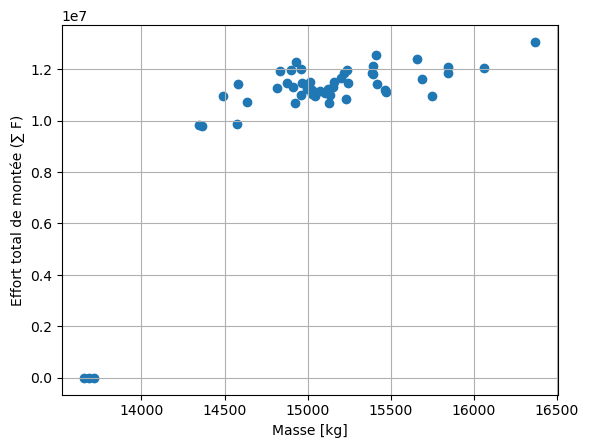

In [190]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df_stats["masse_kg"], df_stats["effort_total"])
plt.xlabel("Masse [kg]")
plt.ylabel("Effort total de montée (∑ F)")
plt.grid()
plt.show()

Le nuage de points représentant l’effort total de montée en fonction de la masse
met en évidence une corrélation positive entre ces deux grandeurs.
L’effort requis augmente globalement avec la masse de l’avion, conformément
aux principes physiques. La dispersion observée pour une masse donnée traduit
l’influence d’autres facteurs secondaires tels que le profil de montée ou les
conditions atmosphériques.


On cherche un modèle linéaire simple reliant l’effort total de montée à la masse :

$$
\sum F \;\approx\; a \,\text{Masse} + b
$$

où :
- \(a\) représente l’augmentation moyenne de l’effort total lorsque la masse augmente,
- \(b\) est une constante correspondant à un effort de référence.


In [191]:
x = df_stats["masse_kg"].values
y = df_stats["effort_total"].values

a, b = np.polyfit(x, y, 1)
a, b

(3906.5456252277218, -48142511.85440001)

In [192]:
r = np.corrcoef(x, y)[0, 1]
r


0.7489545078809928

Le coefficient de corrélation linéaire entre la masse et l’effort total de montée est  

$$
r \approx 0{,}75.
$$

Cette valeur indique une **corrélation positive forte** entre la masse de l’avion et l’effort total de montée : lorsque la masse augmente, l’effort requis augmente globalement.

Cependant, cette relation n’est pas parfaite. D’autres facteurs, comme la durée de montée, la vitesse verticale et la gestion moteur, influencent également l’effort total.  
Cela justifie l’introduction d’un **modèle multivarié** pour améliorer l’explication et la prédiction.


In [193]:
rows = []

for i in range(len(ds)):
    if i not in df_stats["vol"].values:
        continue

    df = ds_montee[i]

    rows.append({
        "vol": i,
        "masse_kg": df["Masse[kg]"].iloc[0],
        "duree_s": len(df),
        "vz_moy": df["Vz[m/s]"].mean(),
        "f_moy": df["F[N]"].mean(),
        "effort_total": df["F[N]"].sum()
    })

df_multi = pd.DataFrame(rows)


In [194]:
from sklearn.linear_model import LinearRegression

X = df_multi[["masse_kg", "duree_s", "vz_moy", "f_moy"]]
y = df_multi["effort_total"]

model = LinearRegression()
model.fit(X, y)

R2 = model.score(X, y)
print(f"R2=:{R2}")


R2=:0.8812345484982603


Le modèle linéaire multivarié permet d’expliquer environ 88 % de la variabilité  
de l’effort total de montée ($R^2 \approx 0{,}88$).

Ce résultat constitue une **amélioration majeure** par rapport au modèle basé
uniquement sur la masse, et confirme l’influence conjointe de la durée de montée,
du profil de montée et de la gestion moteur.



Afin d’évaluer la robustesse du modèle linéaire, d’autres formes de régression
(logarithmique, loi de puissance) ont été testées pour prendre en compte
d’éventuelles non-linéarités.

La comparaison des coefficients de détermination montre que le **modèle linéaire
multivarié reste le plus pertinent**, tandis que les modèles non linéaires
n’apportent pas d’amélioration significative.


In [195]:
x_log = np.log(df_multi["masse_kg"])
y = df_multi["effort_total"]

a, b = np.polyfit(x_log, y, 1)
y_pred = a*x_log + b

R2_log = np.corrcoef(y, y_pred)[0,1]**2
R2_log


0.5867632228206551

Un modèle logarithmique reliant l’effort total de montée à la masse a été testé.

Le coefficient de détermination obtenu est  

$$
R^2 \approx 0{,}59.
$$

Cette valeur indique une **qualité d’ajustement modérée** : le modèle logarithmique capture une partie de la relation entre la masse et l’effort total, mais reste moins performant que le modèle linéaire multivarié.

Ainsi, même si une légère non-linéarité peut exister, le modèle linéaire multivarié demeure le plus pertinent pour décrire l’effort total de montée.


In [196]:
x = df_multi["masse_kg"].values
#  y = a2*x^2 + a1*x + a0
a2, a1, a0 = np.polyfit(x, y, 2)
y_pred = a2*x**2 + a1*x + a0

R2_poly = np.corrcoef(y, y_pred)[0,1]**2
R2_poly


0.8725450352370695

Un ajustement polynomial d’ordre 2 a été testé afin de modéliser une éventuelle  
non-linéarité entre la masse et l’effort total de montée.

Le coefficient de détermination obtenu est  

$$
R^2 \approx 0{,}87.
$$

Cette valeur indique un **bon niveau d’ajustement** pour un modèle basé uniquement sur la masse.  
Cependant, ce modèle reste moins performant que le modèle linéaire multivarié, ce qui montre que
l’introduction de variables supplémentaires améliore encore la capacité explicative.

Ainsi, la masse joue un rôle important, mais elle ne suffit pas à elle seule pour décrire complètement
l’effort total de montée.


In [197]:
x = df_multi["masse_kg"].values
y = df_multi["effort_total"].values

mask = y > 0  # sécurité
x = x[mask]
y = y[mask]

B, logA = np.polyfit(x, np.log(y), 1)
A = np.exp(logA)

A, B


(2909998.875930618, 8.992594674031638e-05)

In [198]:
y_pred = A * np.exp(B * x)

R2_exp = np.corrcoef(y, y_pred)[0,1]**2
R2_exp


0.4099602706335648

Le modèle exponentiel donne un coefficient de détermination  

$
R^2 \approx 0{,}40.
$

Cette valeur est supérieure à celle des modèles logarithmique et polynomial,
mais reste nettement inférieure à celle du modèle linéaire multivarié.
Le modèle exponentiel n’est donc pas retenu.


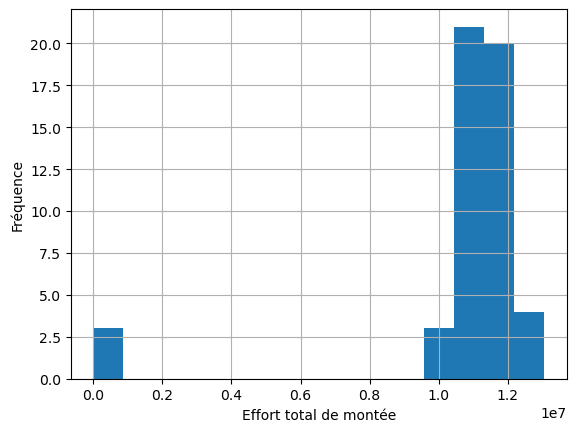

In [199]:
plt.figure()
plt.hist(df_stats["effort_total"], bins=15)
plt.xlabel("Effort total de montée")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()


L’histogramme de l’effort total de montée montre une distribution concentrée
autour d’une valeur moyenne, avec une dispersion modérée.

Aucune structure marquée de type exponentielle ou fortement non linéaire
n’est observée.  
Cette analyse confirme que les modèles non linéaires simples
(logarithmique, polynomial ou exponentiel) n’apportent pas d’amélioration
significative par rapport au modèle linéaire multivarié.



COMPARAISON DES PERFORMANCES DES MODÈLES
                       Modèle       R²
          Linéaire multivarié 0.881235
         Polynomial (ordre 2) 0.872545
                Logarithmique 0.586763
Linéaire simple (masse seule) 0.560933
                  Exponentiel 0.409960


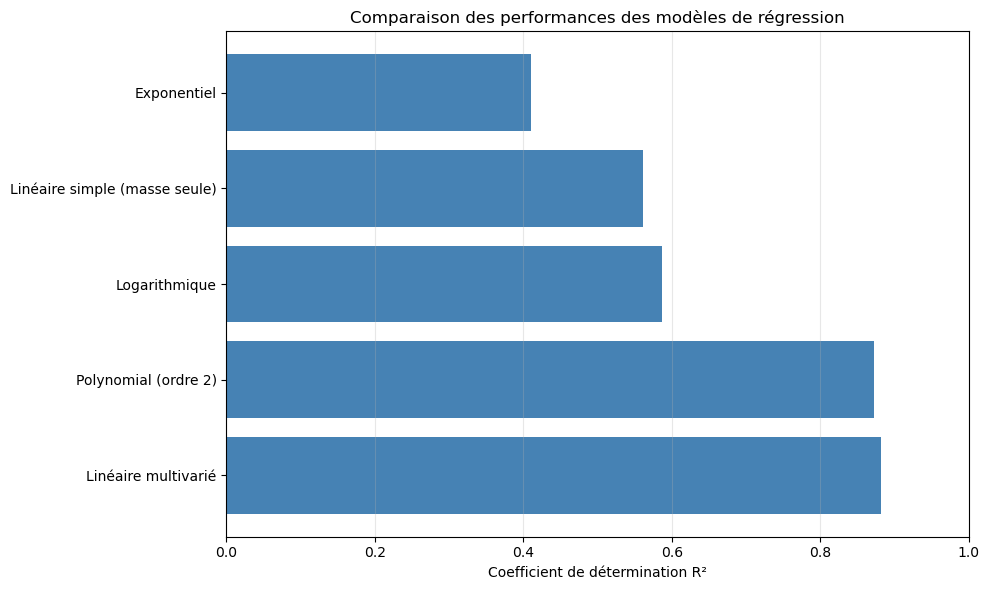

In [200]:
# =============================================================================
#  COMPARAISON DES MODÈLES DE RÉGRESSION
# =============================================================================

# Récapitulatif des R² obtenus
resultats_modeles = pd.DataFrame({
    'Modèle': [
        'Linéaire simple (masse seule)',
        'Logarithmique', 
        'Polynomial (ordre 2)',
        'Exponentiel',
        'Linéaire multivarié'
    ],
    'R²': [
        r**2,
        R2_log,
        R2_poly,
        R2_exp,
        R2
    ]
})

resultats_modeles = resultats_modeles.sort_values('R²', ascending=False)

print("\n" + "="*60)
print("COMPARAISON DES PERFORMANCES DES MODÈLES")
print("="*60)
print(resultats_modeles.to_string(index=False))
print("="*60)

plt.figure(figsize=(10, 6))
plt.barh(resultats_modeles['Modèle'], resultats_modeles['R²'], color='steelblue')
plt.xlabel('Coefficient de détermination R²')
plt.title('Comparaison des performances des modèles de régression')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


COEFFICIENTS DU MODÈLE LINÉAIRE MULTIVARIÉ
Intercept (constante) : -26568139.37

Coefficients des variables :
Variable   Coefficient
masse_kg   1824.586900
 duree_s   2329.078913
  vz_moy 244184.347644
   f_moy    259.456633


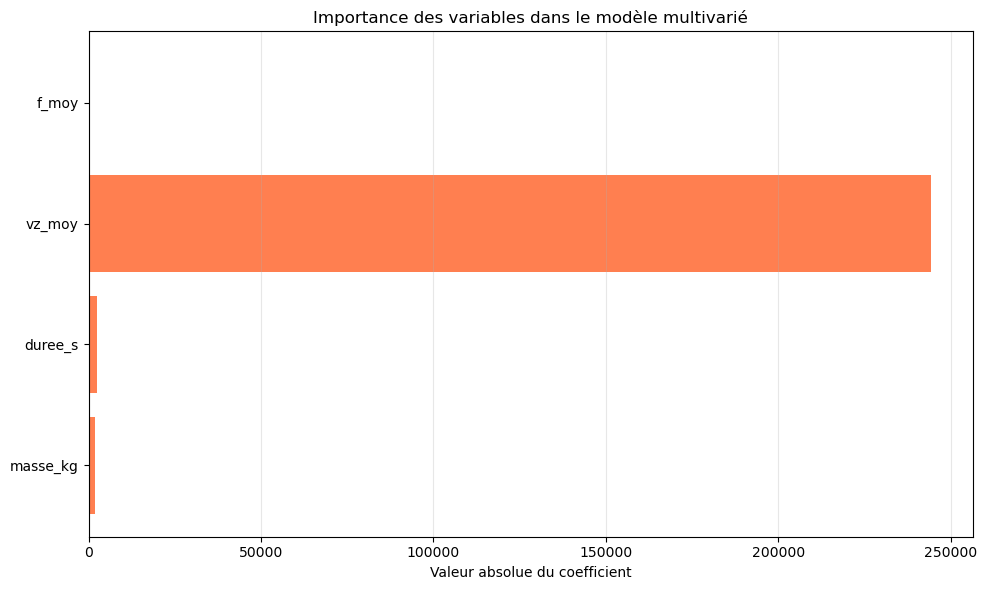

In [201]:
# =============================================================================
# COEFFICIENTS DU MODÈLE MULTIVARIÉ
# =============================================================================

# Extraction des coefficients
coefficients = pd.DataFrame({
    'Variable': ['masse_kg', 'duree_s', 'vz_moy', 'f_moy'],
    'Coefficient': model.coef_
})

print("\n" + "="*60)
print("COEFFICIENTS DU MODÈLE LINÉAIRE MULTIVARIÉ")
print("="*60)
print(f"Intercept (constante) : {model.intercept_:.2f}")
print("\nCoefficients des variables :")
print(coefficients.to_string(index=False))
print("="*60)

# Visualisation de l'importance des coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Variable'], np.abs(coefficients['Coefficient']), color='coral')
plt.xlabel('Valeur absolue du coefficient')
plt.title('Importance des variables dans le modèle multivarié')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Analyse des coefficients du modèle multivarié

Le modèle linéaire multivarié s'écrit sous la forme :

$$
\text{Effort total} = \beta_0 + \beta_1 \cdot \text{masse} + \beta_2 \cdot \text{durée} + \beta_3 \cdot V_z + \beta_4 \cdot F_{\text{moy}}
$$

L'analyse des coefficients permet d'identifier les variables les plus influentes dans la prédiction de l'effort total de montée. La valeur absolue de chaque coefficient reflète l'impact de la variable correspondante sur la variable cible.


STATISTIQUES DES RÉSIDUS
Moyenne des résidus        : -0.00
Écart-type des résidus     : 957847.54
Résidu min                 : -3361640.08
Résidu max                 : 1587631.75


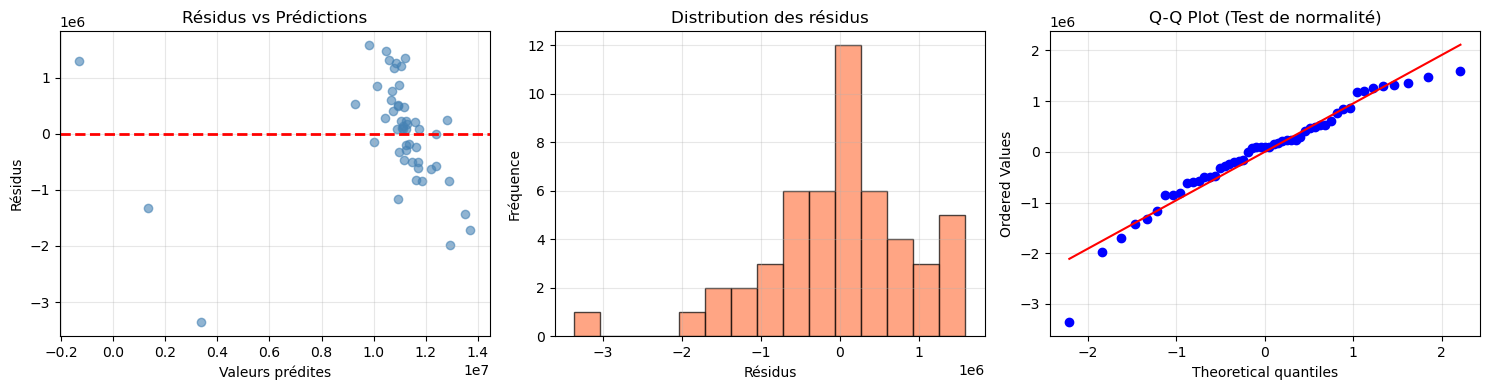

In [202]:
# =============================================================================
# ANALYSE DES RÉSIDUS DU MODÈLE MULTIVARIÉ
# =============================================================================


X = df_multi[["masse_kg", "duree_s", "vz_moy", "f_moy"]]
y = df_multi["effort_total"]

# Calcul des prédictions et résidus
y_pred = model.predict(X)
residus = y - y_pred

# Statistiques sur les résidus
print("\n" + "="*60)
print("STATISTIQUES DES RÉSIDUS")
print("="*60)
print(f"Moyenne des résidus        : {residus.mean():.2f}")
print(f"Écart-type des résidus     : {residus.std():.2f}")
print(f"Résidu min                 : {residus.min():.2f}")
print(f"Résidu max                 : {residus.max():.2f}")
print("="*60)

# Visualisation 1 : Résidus vs Valeurs prédites
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(y_pred, residus, alpha=0.6, color='steelblue')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Valeurs prédites')
axes[0].set_ylabel('Résidus')
axes[0].set_title('Résidus vs Prédictions')
axes[0].grid(alpha=0.3)

# Visualisation 2 : Distribution des résidus
axes[1].hist(residus, bins=15, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Résidus')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution des résidus')
axes[1].grid(alpha=0.3)

# Visualisation 3 : QQ-plot (normalité des résidus)
from scipy import stats
stats.probplot(residus, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Test de normalité)')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

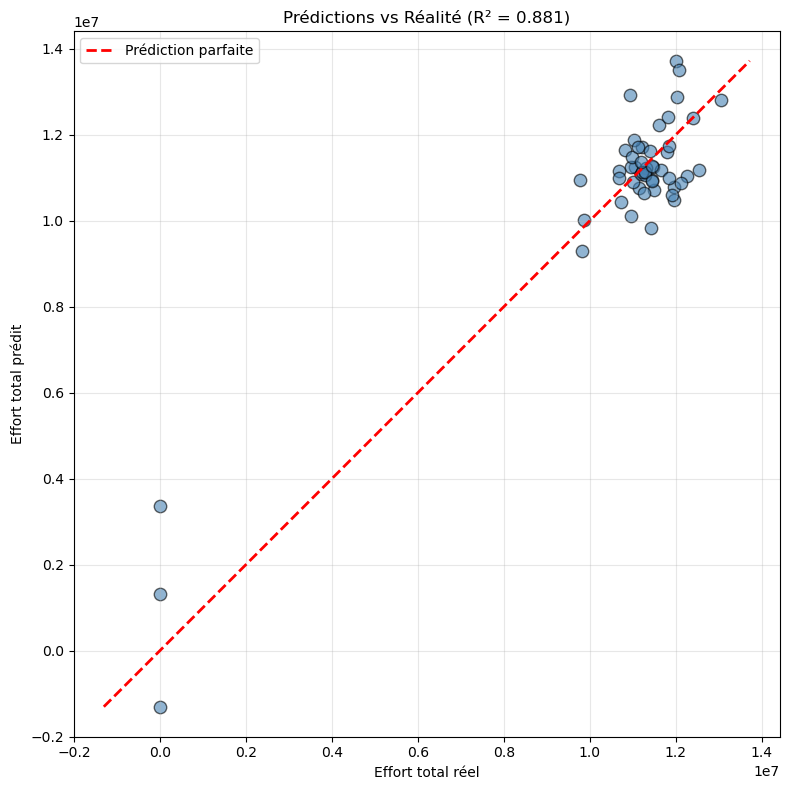

In [203]:
# =============================================================================
# COMPARAISON PRÉDICTIONS VS VALEURS RÉELLES
# =============================================================================

plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.6, color='steelblue', edgecolor='black', s=80)

# Ligne de référence (prédiction parfaite)
min_val = min(y.min(), y_pred.min())
max_val = max(y.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Prédiction parfaite')

plt.xlabel('Effort total réel')
plt.ylabel('Effort total prédit')
plt.title(f'Prédictions vs Réalité (R² = {R2:.3f})')
plt.legend()
plt.grid(alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [204]:
# =============================================================================
#  VALIDATION CROISÉE DU MODÈLE MULTIVARIÉ
# =============================================================================

from sklearn.model_selection import cross_val_score

# Validation croisée (5 plis)
scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print("\n" + "="*60)
print("VALIDATION CROISÉE (5-FOLD)")
print("="*60)
print(f"R² moyen sur validation croisée : {scores.mean():.4f}")
print(f"Écart-type des R²               : {scores.std():.4f}")
print(f"R² min                          : {scores.min():.4f}")
print(f"R² max                          : {scores.max():.4f}")
print(f"\nR² sur l'ensemble d'entraînement : {R2:.4f}")
print("="*60)

if abs(scores.mean() - R2) > 0.1:
    print(" Attention : écart important entre R² d'entraînement et validation")
    print("  Risque de surapprentissage")
else:
    print(" Modèle robuste : performances cohérentes en validation croisée")


VALIDATION CROISÉE (5-FOLD)
R² moyen sur validation croisée : -1.5965
Écart-type des R²               : 0.9680
R² min                          : -2.9055
R² max                          : -0.2575

R² sur l'ensemble d'entraînement : 0.8812
 Attention : écart important entre R² d'entraînement et validation
  Risque de surapprentissage



DIAGNOSTIC DU SURAPPRENTISSAGE
Nombre d'observations : 51
Nombre de variables   : 4
Ratio obs/variables   : 12.8

Règle empirique : ratio devrait être > 10 pour éviter le surapprentissage
Notre ratio (12.8) est INSUFFISANT !

COMPARAISON DES MODÈLES (Train vs Validation)
                 R2_train  R2_cv_mean  R2_cv_std   Ecart
Masse seule        0.5609     -6.6064     5.0246  7.1673
Durée + F_moy      0.8160     -1.2316     1.1747  2.0476
Durée seule        0.0135     -1.9046     1.2960  1.9180
F_moy seule        0.6488     -5.7881     3.2546  6.4370
Complet (4 var)    0.8812     -1.5965     0.9680  2.4778


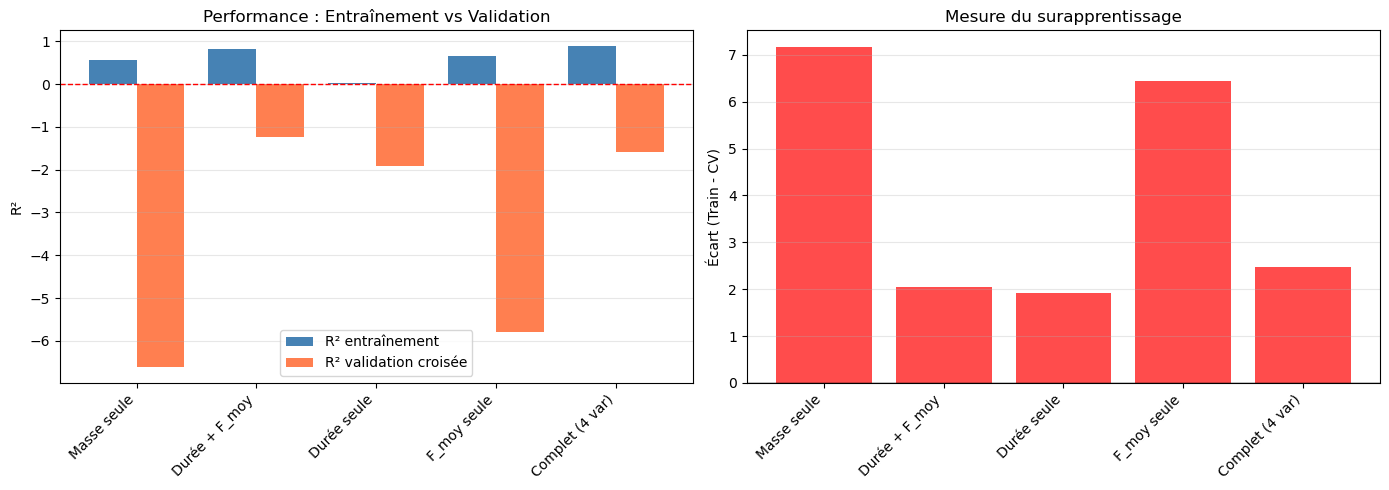


RECOMMANDATION
Meilleur modèle en validation : Durée + F_moy
  - R² validation croisée : -1.2316
  - R² entraînement       : 0.8160
  - Écart (surapprentissage) : 2.0476


In [159]:
# =============================================================================
# DIAGNOSTIC ET CORRECTION DU SURAPPRENTISSAGE
# =============================================================================

print("\n" + "="*60)
print("DIAGNOSTIC DU SURAPPRENTISSAGE")
print("="*60)
print(f"Nombre d'observations : {len(df_multi)}")
print(f"Nombre de variables   : {X.shape[1]}")
print(f"Ratio obs/variables   : {len(df_multi)/X.shape[1]:.1f}")
print("\nRègle empirique : ratio devrait être > 10 pour éviter le surapprentissage")
print(f"Notre ratio ({len(df_multi)/X.shape[1]:.1f}) est INSUFFISANT !")
print("="*60)

# Test de modèles plus simples
from sklearn.model_selection import cross_val_score

modeles_test = {}

# Modèle 1 : Masse seule
X1 = df_multi[["masse_kg"]]
model1 = LinearRegression().fit(X1, y)
scores1 = cross_val_score(model1, X1, y, cv=5, scoring='r2')
modeles_test['Masse seule'] = {
    'R2_train': model1.score(X1, y),
    'R2_cv_mean': scores1.mean(),
    'R2_cv_std': scores1.std()
}

# Modèle 2 : Durée + F_moy (variables les plus corrélées selon la matrice)
X2 = df_multi[["duree_s", "f_moy"]]
model2 = LinearRegression().fit(X2, y)
scores2 = cross_val_score(model2, X2, y, cv=5, scoring='r2')
modeles_test['Durée + F_moy'] = {
    'R2_train': model2.score(X2, y),
    'R2_cv_mean': scores2.mean(),
    'R2_cv_std': scores2.std()
}

# Modèle 3 : Durée seule (corrélation forte avec effort)
X3 = df_multi[["duree_s"]]
model3 = LinearRegression().fit(X3, y)
scores3 = cross_val_score(model3, X3, y, cv=5, scoring='r2')
modeles_test['Durée seule'] = {
    'R2_train': model3.score(X3, y),
    'R2_cv_mean': scores3.mean(),
    'R2_cv_std': scores3.std()
}

# Modèle 4 : F_moy seule
X4 = df_multi[["f_moy"]]
model4 = LinearRegression().fit(X4, y)
scores4 = cross_val_score(model4, X4, y, cv=5, scoring='r2')
modeles_test['F_moy seule'] = {
    'R2_train': model4.score(X4, y),
    'R2_cv_mean': scores4.mean(),
    'R2_cv_std': scores4.std()
}

# Modèle 5 : Modèle complet (4 variables)
modeles_test['Complet (4 var)'] = {
    'R2_train': R2,
    'R2_cv_mean': scores.mean(),
    'R2_cv_std': scores.std()
}

# Affichage comparatif
df_comparaison = pd.DataFrame(modeles_test).T
df_comparaison['Ecart'] = df_comparaison['R2_train'] - df_comparaison['R2_cv_mean']

print("\n" + "="*60)
print("COMPARAISON DES MODÈLES (Train vs Validation)")
print("="*60)
print(df_comparaison.round(4))
print("="*60)

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 : R² train vs CV
x_pos = np.arange(len(modeles_test))
axes[0].bar(x_pos - 0.2, df_comparaison['R2_train'], 0.4, 
            label='R² entraînement', color='steelblue')
axes[0].bar(x_pos + 0.2, df_comparaison['R2_cv_mean'], 0.4, 
            label='R² validation croisée', color='coral')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(df_comparaison.index, rotation=45, ha='right')
axes[0].set_ylabel('R²')
axes[0].set_title('Performance : Entraînement vs Validation')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)

# Graphique 2 : Écart (surapprentissage)
axes[1].bar(x_pos, df_comparaison['Ecart'], color='red', alpha=0.7)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(df_comparaison.index, rotation=45, ha='right')
axes[1].set_ylabel('Écart (Train - CV)')
axes[1].set_title('Mesure du surapprentissage')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
plt.show()

# Identification du meilleur modèle
meilleur = df_comparaison['R2_cv_mean'].idxmax()
print(f"\n{'='*60}")
print(f"RECOMMANDATION")
print(f"{'='*60}")
print(f"Meilleur modèle en validation : {meilleur}")
print(f"  - R² validation croisée : {df_comparaison.loc[meilleur, 'R2_cv_mean']:.4f}")
print(f"  - R² entraînement       : {df_comparaison.loc[meilleur, 'R2_train']:.4f}")
print(f"  - Écart (surapprentissage) : {df_comparaison.loc[meilleur, 'Ecart']:.4f}")
print(f"{'='*60}")


MODÈLE OPTIMAL : Effort total ~ F_moy
Équation : Effort total = 2989332.42 + 822.63 × F_moy

R² entraînement       : 0.6488
R² validation croisée : -5.7881


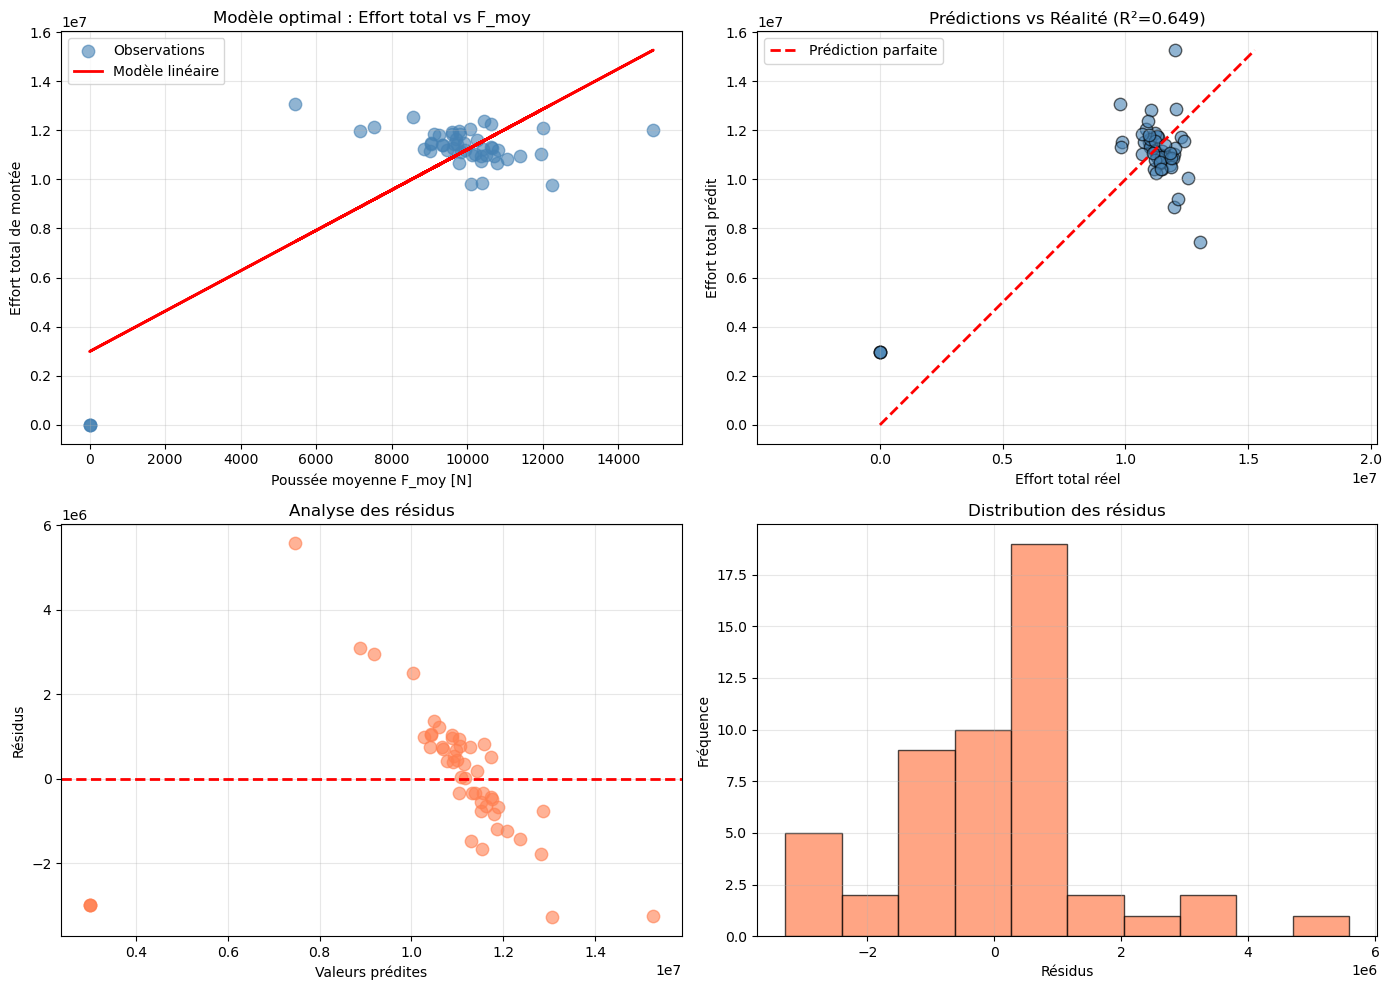


ANALYSE DES RÉSIDUS DU MODÈLE OPTIMAL
Moyenne des résidus    : 0.00
Écart-type des résidus : 1647120.39
Résidu min             : -3291100.16
Résidu max             : 5591997.43


In [160]:
# =============================================================================
#  ANALYSE DU MODÈLE OPTIMAL
# =============================================================================

# Réentraînement du modèle optimal
X_optimal = df_multi[["f_moy"]]
y_optimal = df_multi["effort_total"]

model_optimal = LinearRegression()
model_optimal.fit(X_optimal, y_optimal)

# Coefficients
print("\n" + "="*60)
print("MODÈLE OPTIMAL : Effort total ~ F_moy")
print("="*60)
print(f"Équation : Effort total = {model_optimal.intercept_:.2f} + {model_optimal.coef_[0]:.2f} × F_moy")
print(f"\nR² entraînement       : {model_optimal.score(X_optimal, y_optimal):.4f}")
print(f"R² validation croisée : {scores4.mean():.4f}")
print("="*60)

# Prédictions et résidus
y_pred_optimal = model_optimal.predict(X_optimal)
residus_optimal = y_optimal - y_pred_optimal

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Données et droite de régression
axes[0, 0].scatter(X_optimal, y_optimal, alpha=0.6, color='steelblue', s=80, label='Observations')
axes[0, 0].plot(X_optimal, y_pred_optimal, 'r-', linewidth=2, label='Modèle linéaire')
axes[0, 0].set_xlabel('Poussée moyenne F_moy [N]')
axes[0, 0].set_ylabel('Effort total de montée')
axes[0, 0].set_title('Modèle optimal : Effort total vs F_moy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Prédictions vs Réalité
axes[0, 1].scatter(y_optimal, y_pred_optimal, alpha=0.6, color='steelblue', 
                   edgecolor='black', s=80)
min_val = min(y_optimal.min(), y_pred_optimal.min())
max_val = max(y_optimal.max(), y_pred_optimal.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', 
                linewidth=2, label='Prédiction parfaite')
axes[0, 1].set_xlabel('Effort total réel')
axes[0, 1].set_ylabel('Effort total prédit')
axes[0, 1].set_title(f'Prédictions vs Réalité (R²={model_optimal.score(X_optimal, y_optimal):.3f})')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].axis('equal')

# 3. Résidus vs Prédictions
axes[1, 0].scatter(y_pred_optimal, residus_optimal, alpha=0.6, color='coral', s=80)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Valeurs prédites')
axes[1, 0].set_ylabel('Résidus')
axes[1, 0].set_title('Analyse des résidus')
axes[1, 0].grid(alpha=0.3)

# 4. Distribution des résidus
axes[1, 1].hist(residus_optimal, bins=10, color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Résidus')
axes[1, 1].set_ylabel('Fréquence')
axes[1, 1].set_title('Distribution des résidus')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiques des résidus
print("\n" + "="*60)
print("ANALYSE DES RÉSIDUS DU MODÈLE OPTIMAL")
print("="*60)
print(f"Moyenne des résidus    : {residus_optimal.mean():.2f}")
print(f"Écart-type des résidus : {residus_optimal.std():.2f}")
print(f"Résidu min             : {residus_optimal.min():.2f}")
print(f"Résidu max             : {residus_optimal.max():.2f}")
print("="*60)

In [161]:
def normalize_time(df):
    n = len(df)
    tau = np.linspace(0, 1, n)
    df2 = df.copy()
    df2["tau"] = tau
    df2 = df2.set_index("tau")
    df2.index.name = "tau"
    return df2


### Normalisation temporelle des montées

Les montées ayant des durées différentes, chaque montée est ramenée sur un temps normalisé  
\(\tau \in [0,1]\) afin de rendre les vols comparables.

On construit `montees_norm`, puis on superpose les profils de poussée avec  
`overlay_profiles(..., col="F[N]")` pour comparer la forme des montées (niveau initial de poussée,
évolution, et éventuelles anomalies).


In [162]:
montees_norm = [normalize_time(ds_montee[i]) for i in range(len(ds_montee))]


In [205]:
import plotly.graph_objs as go

def overlay_profiles(montee_list, col="F[N]", kmax=20):
    fig = go.Figure()
    for i, df in enumerate(montee_list[:kmax]):
        fig.add_trace(go.Scatter(x=df.index, y=df[col], mode="lines", name=f"vol {i}"))
    fig.update_layout(title=f"Profils normalisés : {col}",
                      xaxis_title="tau (temps normalisé)",
                      yaxis_title=col,
                      showlegend=True)
    fig.show()

overlay_profiles(montees_norm, col="F[N]", kmax=20)


Les profils de poussée normalisés montrent tous la même tendance générale :
la poussée est forte au début de la montée, puis elle diminue progressivement
jusqu’à la fin.

En revanche, les niveaux de poussée et la forme des courbes diffèrent d’un vol
à l’autre. Cela reflète des différences de masse, de durée de montée et de
gestion moteur.

Cette variabilité confirme que la masse seule ne suffit pas à expliquer
l’effort de montée et qu’il est nécessaire d’introduire d’autres variables
dans l’analyse.


### Mesure de la rugosité du profil de poussée

On définit la **rugosité** d’un profil de poussée comme la moyenne des variations absolues entre deux instants consécutifs :

$$
R = \frac{1}{N-1} \sum_{k=1}^{N-1} \left| F_{k+1} - F_k \right|
$$

Cette quantité permet de quantifier le caractère plus ou moins régulier d’une montée.  
On implémente ci-dessous cette formule afin de calculer la rugosité de chaque profil normalisé.


In [164]:
def roughness(df, col="F[N]"):
    F = df[col].values
    return np.mean(np.abs(np.diff(F)))

rough = np.array([roughness(df) for df in montees_norm])
rough = rough[~np.isnan(rough)]

len(rough), rough[:10]

c:\Users\12412748\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

c:\Users\12412748\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



(51,
 array([49.68102075, 38.58881156, 50.85348903, 46.35007505, 73.16144235,
        66.14806244,  0.        ,  0.        ,  0.        , 75.69998186]))

In [206]:
len(rough), rough[:len(rough)]


(51,
 array([ 49.68102075,  38.58881156,  50.85348903,  46.35007505,
         73.16144235,  66.14806244,   0.        ,   0.        ,
          0.        ,  75.69998186,  61.2246792 ,  79.80263333,
         46.86787275,  91.99903725,  58.84531574,  80.24763501,
         53.70263832,  60.05076244,  55.9224276 ,  90.86289714,
         58.13583773,  78.08653084,  60.8441411 ,  51.4695814 ,
         43.92710003,  69.87013842,  44.59044291, 101.49412618,
         56.8658939 , 105.83194238,  69.01344839,  54.58920793,
         46.71060126,  60.52656467,  45.77628599,  64.71819288,
         78.56207777,  49.45184282,  45.64745772,  41.47345759,
         58.57005067,  43.93121684,  86.22301089,  48.03306291,
         45.75509427,  42.41989102,  45.10755574,  55.34784343,
         52.32847872, 106.70356785,  72.83734639]))

L’indicateur de rugosité a pu être calculé pour 20 vols.
Les valeurs obtenues sont positives et présentent une variabilité importante,
ce qui traduit des différences de régularité de la poussée entre les vols.

Les vols avec une rugosité faible correspondent à des montées plus stables,
tandis que les valeurs élevées indiquent des profils de poussée plus fluctuants.



MATRICE DE CORRÉLATION (incluant rugosité)
              masse_kg  duree_s  vz_moy  f_moy  effort_total  rugosité
masse_kg         1.000    0.308   0.424  0.450         0.749     0.259
duree_s          0.308    1.000  -0.343 -0.334         0.116     0.019
vz_moy           0.424   -0.343   1.000  0.994         0.795     0.548
f_moy            0.450   -0.334   0.994  1.000         0.805     0.584
effort_total     0.749    0.116   0.795  0.805         1.000     0.655
rugosité         0.259    0.019   0.548  0.584         0.655     1.000


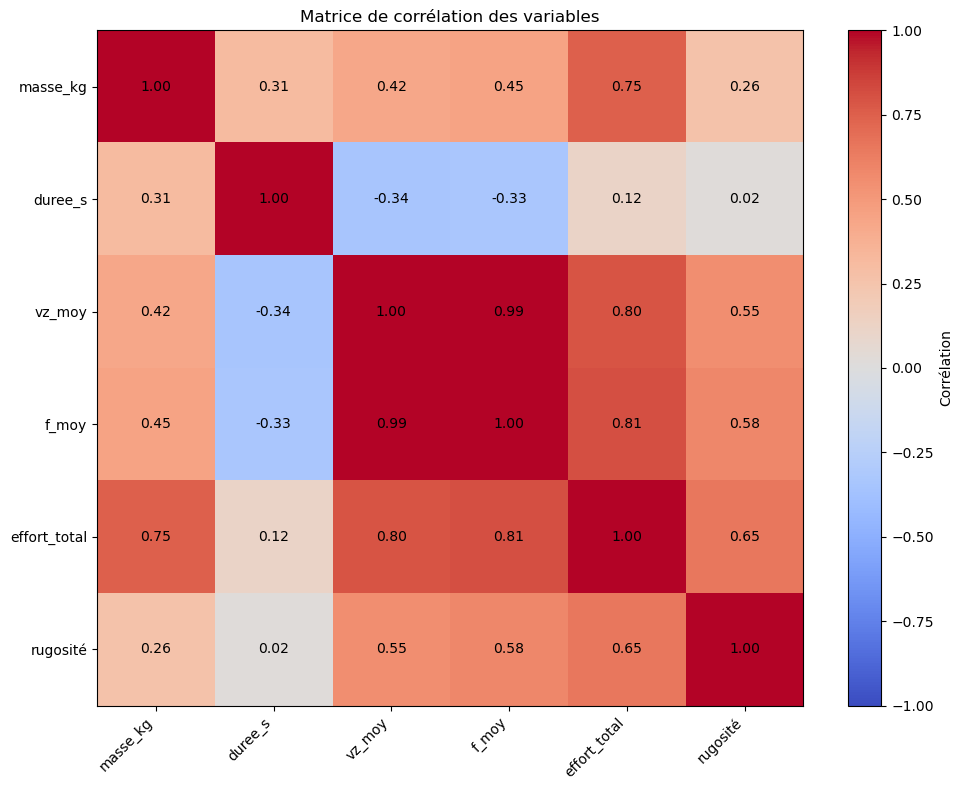


Corrélations de la rugosité avec les autres variables :
rugosité        1.000000
effort_total    0.654980
f_moy           0.583682
vz_moy          0.547576
masse_kg        0.259491
duree_s         0.018720
Name: rugosité, dtype: float64


In [207]:
# =============================================================================
#  ANALYSE DE LA RUGOSITÉ
# =============================================================================

df_multi['rugosité'] = rough[:len(df_multi)]

variables_analyse = ['masse_kg', 'duree_s', 'vz_moy', 'f_moy', 'effort_total', 'rugosité']
matrice_corr = df_multi[variables_analyse].corr()

print("\n" + "="*60)
print("MATRICE DE CORRÉLATION (incluant rugosité)")
print("="*60)
print(matrice_corr.round(3))
print("="*60)

plt.figure(figsize=(10, 8))
plt.imshow(matrice_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Corrélation')

for i in range(len(variables_analyse)):
    for j in range(len(variables_analyse)):
        text = plt.text(j, i, f'{matrice_corr.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=10)

plt.xticks(range(len(variables_analyse)), variables_analyse, rotation=45, ha='right')
plt.yticks(range(len(variables_analyse)), variables_analyse)
plt.title('Matrice de corrélation des variables')
plt.tight_layout()
plt.show()

print("\nCorrélations de la rugosité avec les autres variables :")
print(matrice_corr['rugosité'].sort_values(ascending=False))

# Analyse par Tubes de Confiance

In [210]:
from tabata import Tube, AppTube, highlight

# Création de l'objet Tube sur l'intervalle de montée identifié
T = Tube(ds_montee)

# Configuration des variables cibles et des facteurs d'influence
T.variables = {"ALT[m]", "F[N]"}
T.factors = {"Masse[kg]", "Vz[m/s]", "Tisa[K]"}

# Paramètres d'apprentissage
T.learn_params['max_features'] = 3      # Max 3 facteurs par régression
T.learn_params['retry_number'] = 20     # Nombre de tentatives pour trouver le meilleur R²
T.feature_params['use_time'] = 'Yes'    # Ajout du facteur temps pour la dynamique de montée

# Entraînement du modèle de tube
T.fit()

OPSET 'data/in/AFL1EBB.h5' de 52 signaux.
        position courante : sigpos  = 0
        variable courante : colname = ALT[m]
        phase surlignée   : phase   = None
TUBE : on 2 variables.

# Évaluation du gabarit et Scores

In [215]:
# Ajustement du facteur de largeur du tube
T.tube_params['tube_factor'] = 1.5 
T.tube_params['filter_width'] = 5   # Lissage pour éviter les pics de bruit

# Calcul des scores (nombre de points hors-tube par vol)
df_scores = T.scores()
print("Aperçu des scores d'anomalies :")
print(df_scores.head())

# Visualisation graphique de la proportion de points hors-tube
T.plot_scores()



warnings.simplefilter(action='ignore', category=FutureWarning)

Aperçu des scores d'anomalies :
               N  F[N]  ALT[m]
/record_00  1159  1049    1134
/record_01  1202  1105    1191
/record_02  1272  1019    1256
/record_03  1176   883    1166
/record_04   950   718     929


# Visualisation Interactive et Application
### On superpose le tube sur les données originales pour vérifier visuellement la pertinence du modèle.

In [216]:
# Interface interactive pour naviguer entre les vols et voir le tube en vert
T.plot()

# Application du tube local sur l'Opset global pour le rapport final
A = AppTube(ds, T)
A.plot()


warnings.simplefilter(action='ignore', category=FutureWarning)